# Median $DM_{\rm cosmic}$

In [35]:
# imports
from importlib import reload
import numpy as np

from matplotlib import pyplot as plt

from astropy.cosmology import Planck18

from frb.dm import prob_dmz
from frb.figures import utils as fig_utils

from zdm.craco import loading
from zdm import parameters

In [53]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Load up

## zdm

In [13]:
state = parameters.State()
state.set_astropy_cosmo(Planck18)
state.FRBdemo.alpha_method = 1

In [14]:
state

{
    "FRBdemo": {
        "alpha_method": 1,
        "lC": 4.19,
        "sfr_n": 1.77,
        "source_evolution": 0
    },
    "IGM": {
        "F": 0.32
    },
    "MW": {
        "DMhalo": 50.0,
        "ISM": 35.0
    },
    "analysis": {
        "NewGrids": true,
        "sprefix": "Std"
    },
    "beam": {
        "Wbins": 5,
        "Wscale": 3.5,
        "method": 2,
        "thresh": 0
    },
    "cosmo": {
        "H0": 67.66,
        "Omega_b": 0.04897,
        "Omega_b_h2": 0.0224178568132,
        "Omega_k": 0.0,
        "Omega_lambda": 0.6888463055445441,
        "Omega_m": 0.30966,
        "fix_Omega_b_h2": true
    },
    "energy": {
        "alpha": 1.54,
        "gamma": -1.16,
        "lEmax": 41.84,
        "lEmin": 30.0,
        "luminosity_function": 0
    },
    "host": {
        "lmean": 2.16,
        "lsigma": 0.51
    },
    "width": {
        "logmean": 1.70267,
        "logsigma": 0.899148
    }
}

In [15]:
reload(loading)
base_survey='CRAFT_CRACO_MC_base'
survey, grid = loading.survey_and_grid(survey_name=base_survey, init_state=state)

Loading survey: CRAFT_CRACO_MC_base
FRB survey sucessfully initialised with  100  FRBs starting from 0
Initialised grid


In [26]:
grid.zvals.size

500

## FRB

### This takes ~10min

In [18]:
reload(prob_dmz)
z, DM_cosmic, PDMz = prob_dmz.grid_P_DMcosmic_z(F=grid.state.IGM.F, 
                                                zvals=grid.zvals,
                                                DM_cosmics=grid.dmvals,
                                                cosmo=Planck18)

In [20]:
PDMz.shape

(1400, 500)

In [42]:
PDMz[0:50,0]

array([7.68756474e-01, 1.41190211e-01, 4.30793672e-02, 1.82996027e-02,
       9.39215511e-03, 5.44108443e-03, 3.42831440e-03, 2.29740156e-03,
       1.61383495e-03, 1.17662381e-03, 8.84084305e-04, 6.81007140e-04,
       5.35651448e-04, 4.28884817e-04, 3.48706740e-04, 2.87330230e-04,
       2.39552148e-04, 2.01805833e-04, 1.71590779e-04, 1.47118609e-04,
       1.27087269e-04, 1.10533473e-04, 9.67341807e-05, 8.51394991e-05,
       7.53261781e-05, 6.69648482e-05, 5.97965978e-05, 5.36159978e-05,
       4.82586443e-05, 4.35919092e-05, 3.95080003e-05, 3.59187002e-05,
       3.27513418e-05, 2.99457016e-05, 2.74515835e-05, 2.52269235e-05,
       2.32362934e-05, 2.14497109e-05, 1.98416872e-05, 1.83904609e-05,
       1.70773772e-05, 1.58863823e-05, 1.48036102e-05, 1.38170424e-05,
       1.29162275e-05, 1.20920470e-05, 1.13365220e-05, 1.06426500e-05,
       1.00042682e-05, 9.41593866e-06])

### Need Host

In [36]:
muDMhost=np.log(10**grid.state.host.lmean)
sigmaDMhost=np.log(10**grid.state.host.lsigma)
meanHost = np.exp(muDMhost + sigmaDMhost**2/2.)
medianHost = np.exp(muDMhost) 

# Median time

## zdm

In [23]:
grid.rates.shape

(500, 1400)

In [27]:
zdm_cumP = np.cumsum(grid.rates, axis=1)
zdm_cumP.shape

(500, 1400)

### Loop

In [31]:
zdm_medDM = []
for ii in range(grid.zvals.size):
    norm = zdm_cumP[ii,:]/zdm_cumP[ii,-1]
    imed = np.argmin(np.abs(norm-0.5))
    zdm_medDM.append(grid.dmvals[imed])

## FRB

In [49]:
FRB_cumP = np.cumsum(PDMz, axis=0)

In [50]:
FRB_medDM = []
for ii in range(grid.zvals.size):
    norm = FRB_cumP[:,ii] / FRB_cumP[-1,ii]
    imed = np.argmin(np.abs(norm-0.5))
    FRB_medDM.append(DM_cosmic[imed] + medianHost)
    if ii < 10:
        print(FRB_medDM[-1], DM_cosmic[imed], imed, norm[imed])

149.54397707459285 5.0 0 0.7687564735686636
154.54397707459285 10.0 1 0.548649224846819
159.54397707459285 15.0 2 0.4532106097320653
164.54397707459285 20.0 3 0.42842436489924823
174.54397707459285 30.0 5 0.5682023073112826
179.54397707459285 35.0 6 0.5223338031064254
184.54397707459285 40.0 7 0.4825082428923636
189.54397707459285 45.0 8 0.4478165176673817
199.54397707459285 55.0 10 0.5239300033623848
204.54397707459285 60.0 11 0.492412281136799


# Plot

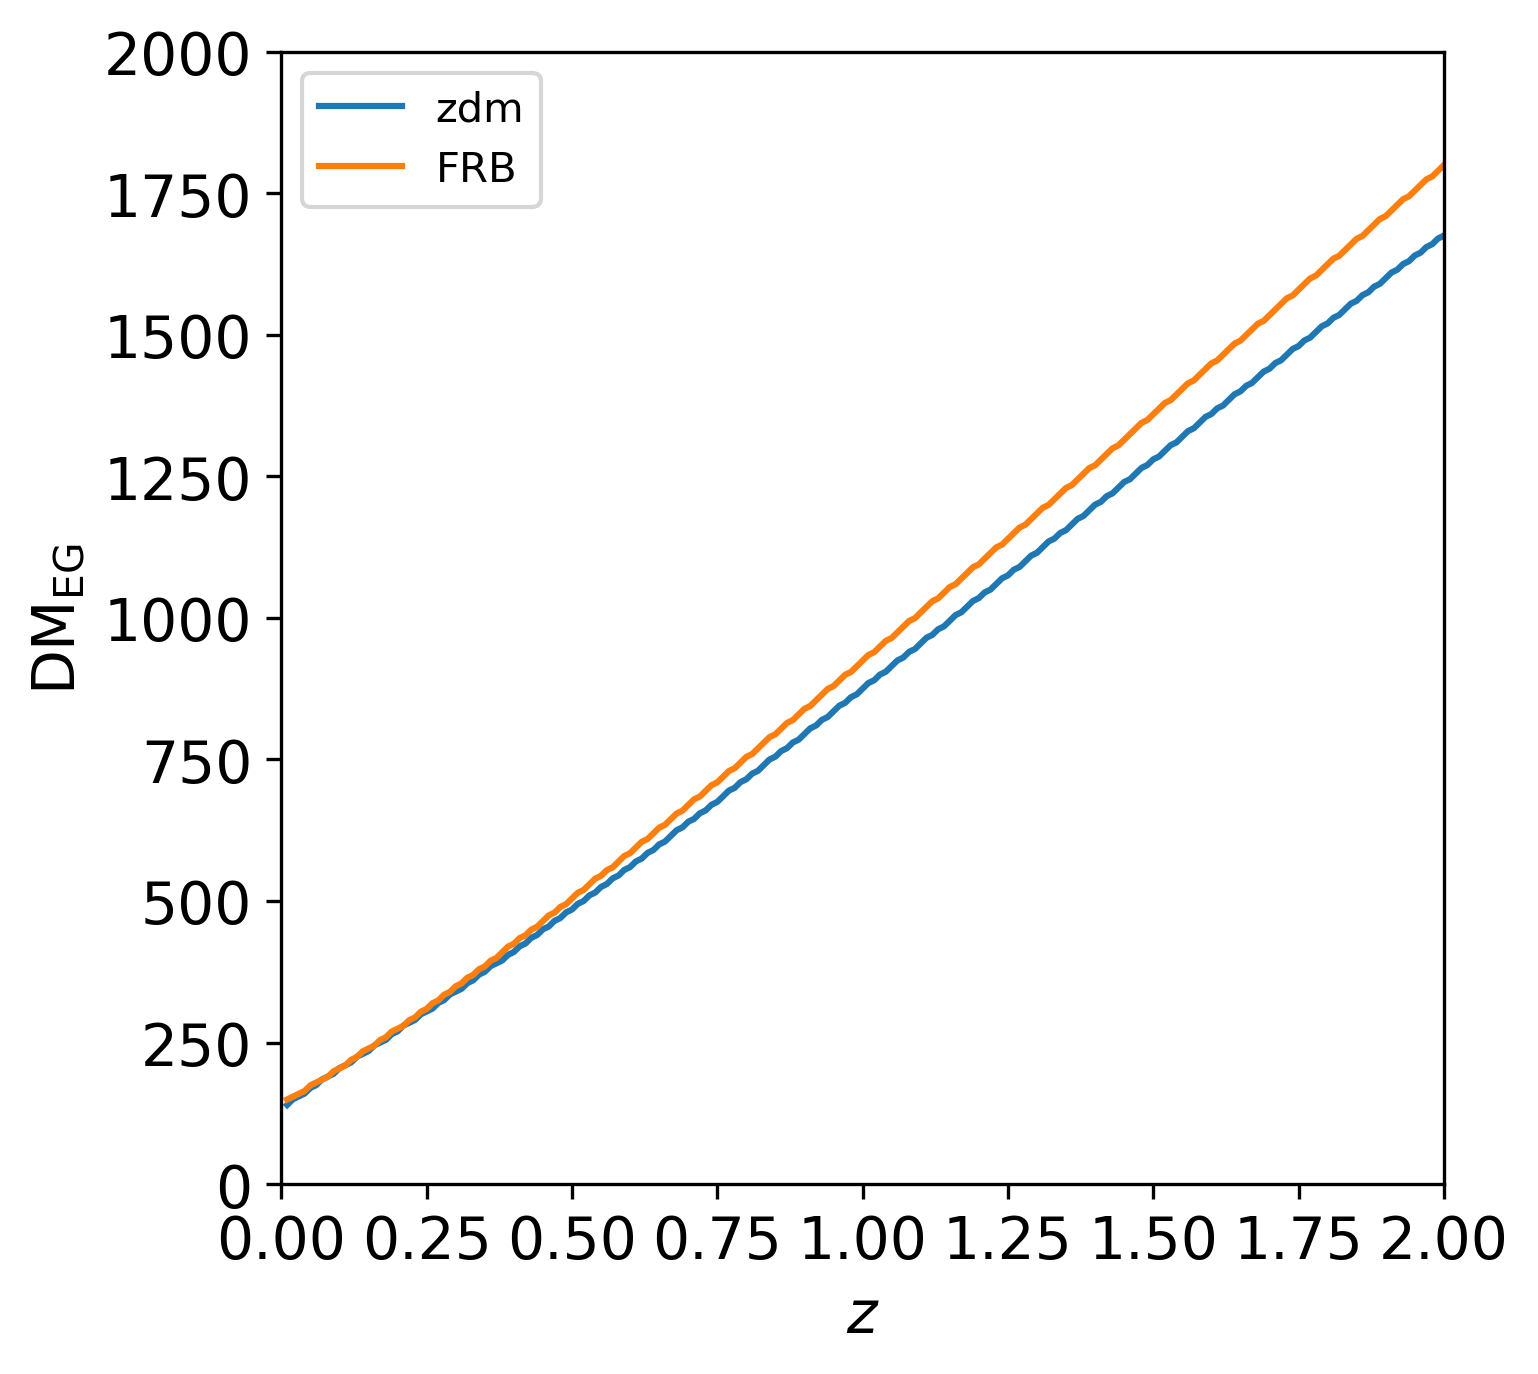

In [56]:
plt.figure(figsize=(5,5))
plt.clf()
ax = plt.gca()
ax.plot(grid.zvals, zdm_medDM, label='zdm')
ax.plot(grid.zvals, FRB_medDM, label='FRB')
ax.legend()
#
ax.set_xlim(0., 2)
ax.set_ylim(0., 2000)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'DM$_{\rm EG}$')
#
fig_utils.set_fontsize(ax, 14.)
plt.savefig('Median_DMcosmic.png', dpi=200)
plt.show()